In [8]:
# datasets/prepare_data.py

import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from typing import Tuple, List

# MNIST transforms
""" MNIST_transform_train = transforms.Compose(
    [
        transforms.RandomCrop(28, padding=4),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
) """

MNIST_transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

MNIST_transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# CIFAR-10 transforms
cifar10_transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

cifar10_transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)


def get_dataloaders(
    n: int, dataset_name: str, batch_size: int, repeat: int = 1
) -> Tuple[List[torch.utils.data.DataLoader], torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    generator = torch.Generator()
    generator.manual_seed(seed)

    if dataset_name == "CIFAR10":
        transform_train, transform_test = (
            cifar10_transform_train,
            cifar10_transform_test,
        )
        trainset = torchvision.datasets.CIFAR10(
            root="/root/GanLuo/ICML2025_project/data/raw/CIFAR10",
            train=True,
            download=False,
            transform=transform_train,
        )
        testset = torchvision.datasets.CIFAR10(
            root="/root/GanLuo/ICML2025_project/data/raw/CIFAR10",
            train=False,
            download=False,
            transform=transform_test,
        )
    elif dataset_name == "MNIST":
        transform_train, transform_test = MNIST_transform_train, MNIST_transform_test
        trainset = torchvision.datasets.MNIST(
            root="/Users/luogan/Code/ICML2025_project/data/raw/MNIST",
            train=True,
            download=False,
            transform=transform_train,
        )
        testset = torchvision.datasets.MNIST(
            root="/Users/luogan/Code/ICML2025_project/data/raw/MNIST",
            train=False,
            download=False,
            transform=transform_test,
        )
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    # Save the original trainset for full_trainloader
    original_trainset = trainset

    # Repeat the training dataset if repeat > 1
    if repeat > 1:
        trainset = torch.utils.data.ConcatDataset([trainset] * repeat)

    total_train_size = len(trainset)
    subset_sizes = [
        total_train_size // n + (1 if i < total_train_size % n else 0) for i in range(n)
    ]

    subsets = torch.utils.data.random_split(trainset, subset_sizes, generator=generator)

    trainloader_list = [
        torch.utils.data.DataLoader(
            subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            prefetch_factor=2,
            persistent_workers=True,
            generator=generator,
        )
        for subset in subsets
    ]

    # Create a DataLoader for the full training set using the original trainset
    full_trainloader = torch.utils.data.DataLoader(
        original_trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True,
        generator=generator,
    )

    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=100,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True,
        generator=generator,
    )

    return trainloader_list, testloader, full_trainloader


def get_dataloaders_high_hetero(
    n: int, dataset_name: str, batch_size: int, repeat: int = 1
) -> Tuple[List[torch.utils.data.DataLoader], torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    generator = torch.Generator()
    generator.manual_seed(seed)

    # Load dataset
    if dataset_name == "CIFAR10":
        transform_train, transform_test = (
            cifar10_transform_train,
            cifar10_transform_test,
        )
        trainset = torchvision.datasets.CIFAR10(
            root="/root/GanLuo/ICML2025_project/data/raw/CIFAR10",
            train=True,
            download=False,
            transform=transform_train,
        )
        testset = torchvision.datasets.CIFAR10(
            root="/root/GanLuo/ICML2025_project/data/raw/CIFAR10",
            train=False,
            download=False,
            transform=transform_test,
        )
        num_classes = 10
    elif dataset_name == "MNIST":
        transform_train, transform_test = MNIST_transform_train, MNIST_transform_test
        trainset = torchvision.datasets.MNIST(
            root="/Users/luogan/Code/ICML2025_project/data/raw/MNIST",
            train=True,
            download=False,
            transform=transform_train,
        )
        testset = torchvision.datasets.MNIST(
            root="/Users/luogan/Code/ICML2025_project/data/raw/MNIST",
            train=False,
            download=False,
            transform=transform_test,
        )
        num_classes = 10
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    # Save original trainset for full_trainloader
    original_trainset = trainset

    # Repeat the training dataset if repeat > 1
    if repeat > 1:
        trainset = torch.utils.data.ConcatDataset([trainset] * repeat)

    # Get labels and create class-specific indices
    labels = np.array(trainset.targets)
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    # Create heterogeneous distributions for each node
    subsets = []
    total_size = len(trainset)
    base_size = total_size // n
    
    # Generate Dirichlet distribution for class proportions across nodes
    alpha = 0.5  # Lower alpha means higher heterogeneity
    class_dist = np.random.dirichlet([alpha] * n, num_classes)
    
    # Assign samples to each node
    for node in range(n):
        node_indices = []
        node_size = base_size + (1 if node < total_size % n else 0)
        
        # Calculate target number of samples per class for this node
        target_dist = class_dist[:, node] * node_size
        
        for cls in range(num_classes):
            num_samples = int(target_dist[cls])
            available_indices = class_indices[cls]
            
            if len(available_indices) > 0:
                selected = np.random.choice(
                    available_indices,
                    size=min(num_samples, len(available_indices)),
                    replace=False
                )
                node_indices.extend(selected)
                # Remove used indices
                class_indices[cls] = np.setdiff1d(class_indices[cls], selected)
                
        subsets.append(torch.utils.data.Subset(trainset, node_indices))

    # Create DataLoaders for each subset
    trainloader_list = [
        torch.utils.data.DataLoader(
            subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            prefetch_factor=2,
            persistent_workers=True,
            generator=generator,
        )
        for subset in subsets
    ]

    # Full training set DataLoader
    full_trainloader = torch.utils.data.DataLoader(
        original_trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True,
        generator=generator,
    )

    # Test set DataLoader
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=100,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True,
        generator=generator,
    )

    return trainloader_list, testloader, full_trainloader



import seaborn as sns
import matplotlib.pyplot as plt

def visualize_heatmap(trainloader_list, num_classes=10):
    num_nodes = len(trainloader_list)
    class_counts = np.zeros((num_nodes, num_classes))

    # 统计类别分布
    for node_idx, loader in enumerate(trainloader_list):
        for _, labels in loader:
            for cls in range(num_classes):
                class_counts[node_idx, cls] += (labels == cls).sum().item()

    # 绘制热力图
    plt.figure(figsize=(8, 6))
    sns.heatmap(class_counts, annot=True, fmt='.0f', cmap='YlOrRd')
    plt.xlabel('type')
    plt.ylabel('node')
    plt.title('heatmap of class distribution')
    plt.show()

# 调用示例
# visualize_heatmap(trainloader_list)

from scipy.stats import entropy

def visualize_kl_divergence(trainloader_list, num_classes=10):
    num_nodes = len(trainloader_list)
    class_counts = np.zeros((num_nodes, num_classes))

    # 统计类别分布
    for node_idx, loader in enumerate(trainloader_list):
        for _, labels in loader:
            for cls in range(num_classes):
                class_counts[node_idx, cls] += (labels == cls).sum().item()

    # 计算比例
    class_ratios = class_counts / class_counts.sum(axis=1, keepdims=True)
    mean_dist = class_ratios.mean(axis=0)  # 平均分布

    # 计算KL散度
    kl_divs = [entropy(class_ratios[i], mean_dist) for i in range(num_nodes)]

    # 绘制
    plt.bar(range(num_nodes), kl_divs)
    plt.xticks(range(num_nodes), [f'node {i+1}' for i in range(num_nodes)])
    plt.ylabel('KL divergence')
    plt.xlabel('node')
    plt.title('KL divergence of class distribution')
    plt.show()

# 调用示例
# visualize_kl_divergence(trainloader_list)

In [ ]:
n = 16
dataset_name = "MNIST"
batch_size = 128
repeat = 1

trainloader_list, testloader, full_trainloader = get_dataloaders(n, dataset_name, batch_size, repeat)

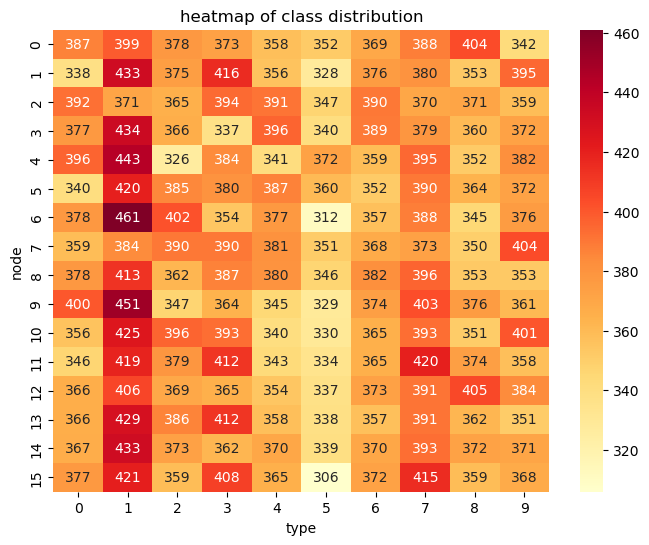

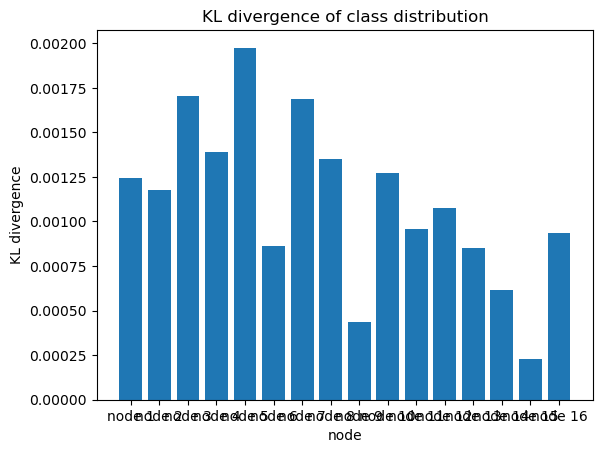

In [6]:
visualize_heatmap(trainloader_list)
visualize_kl_divergence(trainloader_list)

In [9]:
n = 16
dataset_name = "MNIST"
batch_size = 128
repeat = 1

trainloader_list, testloader, full_trainloader = get_dataloaders_high_hetero(n, dataset_name, batch_size, repeat)

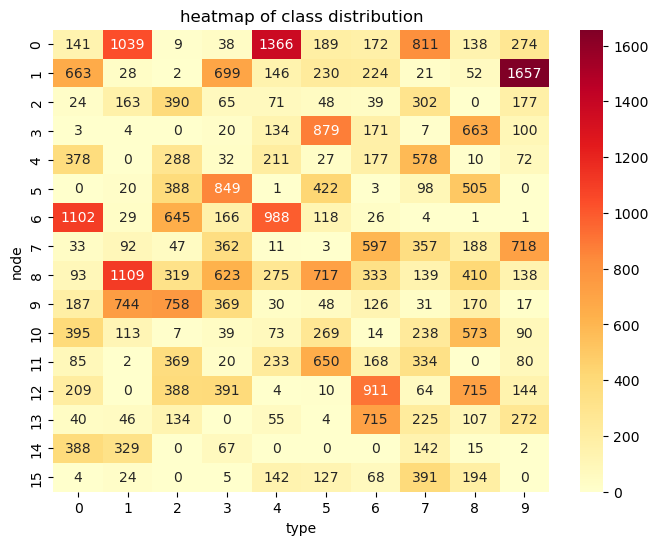

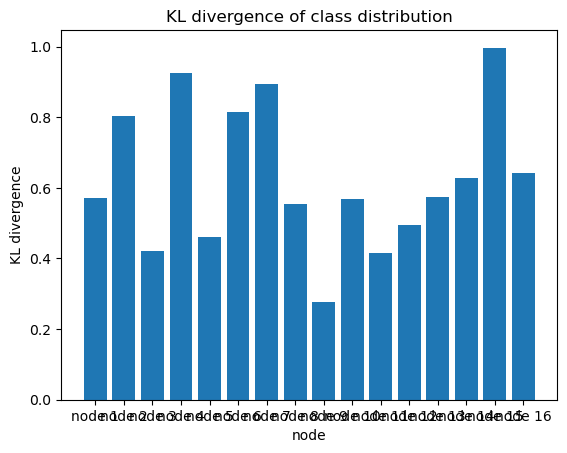

In [10]:
visualize_heatmap(trainloader_list)
visualize_kl_divergence(trainloader_list)